In [40]:
#4.3

# Importing necessary packages
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy import stats

A flat field is a calibration image taken with an evenly illuminated light source, often a uniformly lit screen or twilight sky. It is used in astronomy and other imaging fields to correct for variations in the sensitivity of the pixels in the detector (such as a CCD or CMOS camera) and for optical effects like vignetting or dust on the lens or sensor. By removing the pixel-to-pixel variations and other artifacts, flat fielding ensures that the recorded brightness values of astronomical objects are more accurate, which is crucial for precise photometric measurements.

In [41]:
#4.3.1

def create_median_flat(file_template, dark_file_template, start_index, end_index):
    """
    Create a median flat field by median-combining flat field frames and subtracting the median dark frame.

    :param file_template: Template path for the flat field files with placeholders for the frame number.
    :type file_template: str
    :param dark_file_template: Template path for the dark frame files with placeholders for the frame number.
    :type dark_file_template: str
    :param start_index: The starting index for the flat field frames.
    :type start_index: int
    :param end_index: The ending index for the flat field frames.
    :type end_index: int
    :return: Master flat field (2D np.ndarray), Stack of individual flat fields (3D np.ndarray)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # List to store the data from each flat field and dark frame
    flat_fields_data = []
    dark_frames_data = []
    # Loop through each frame and read both flat field and dark frame data
    for i in range(start_index, end_index + 1):
        # Construct the file name for the flat field
        flat_file_path = file_template.format(i)
        # Open the flat field FITS file and extract the data
        with fits.open(flat_file_path) as hdul:
            flat_fields_data.append(hdul[0].data)
        # Construct the file name for the dark frame
        dark_file_path = dark_file_template.format(i)
        # Open the dark frame FITS file and extract the data
        with fits.open(dark_file_path) as hdul_dark:
            dark_frames_data.append(hdul_dark[0].data)
    # Stack the frames into 3D arrays (stack of 2D frames)
    stacked_flat_frames = np.stack(flat_fields_data, axis=0)
    stacked_dark_frames = np.stack(dark_frames_data, axis=0)
    # Calculate the median across the flat frames (axis=0)
    master_flat_frame = np.median(stacked_flat_frames, axis=0)
    # Calculate the median across the dark frames (axis=0)
    median_dark_frame = np.median(stacked_dark_frames, axis=0)
    # Subtract the median dark frame from the master flat frame
    master_flat_field_corrected = master_flat_frame - median_dark_frame

    return master_flat_field_corrected, stacked_flat_frames

# Template for the flat field file names (with placeholder)
flat_file_template = r"..\FITS_Files\3.3.4_3_flat_fields_10_sec_BLUE.{:08d}.FLAT.FIT"
# Template for the dark frame file names (with placeholder)
dark_file_template = r"..\FITS_Files\3.3.4_3_dark_frames_10_sec_BLUE.{:08d}.DARK.FIT"

# Defining the starting and ending indexes for both flat fields and dark frames
start_index = 0 
end_index = 9

# Call the function
master_flat_field_corrected, stacked_flat_frames = create_median_flat(flat_file_template, dark_file_template, start_index, end_index)

This function above generates a master flat-field image by combining multiple flat-field frames using their median values and subtracting the corresponding median dark frame. The process begins by loading individual flat-field images, which are taken to capture the pixel response variations and optical imperfections. Simultaneously, the function loads matching dark frames taken with the same exposure time and filter to account for the sensor's inherent noise. After stacking the flat and dark frames separately, the median flat-field is computed and corrected by subtracting the median dark frame. This corrected flat field is then returned for calibration purposes.

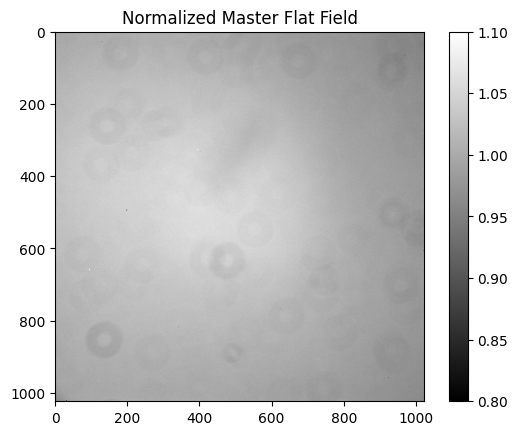

In [42]:
def normalize_flat_field(median_flat_field, save_path):
    """
    Normalize the median flat field by dividing by the mode of its pixel values and scaling 
    appropriately.

    :param median_flat_field: The median flat field to be normalized.
    :type median_flat_field: np.ndarray
    :param save_path: Path to save the scaled normalized flat field FITS file.
    :type save_path: str
    :return: Scaled and normalized flat field.
    :rtype: np.ndarray
    """
    # Flatten the median flat field to 1D for mode calculation
    flat_median = median_flat_field.flatten()
    # Calculate the mode of the flattened median values
    mode_value = stats.mode(flat_median, keepdims=True)[0][0]
    # Normalize the median flat field by dividing by the mode
    norm_flat = median_flat_field / mode_value
    # Plot the normalized flat field
    plt.imshow(norm_flat, cmap='gray', vmin=0.8, vmax=1.1)
    plt.colorbar()
    plt.title("Normalized Master Flat Field")
    plt.show()

    # Save the scaled normalized flat field as a FITS file
    hdu = fits.PrimaryHDU(norm_flat)
    hdu.writeto(save_path, overwrite=True)

    return norm_flat

# Define the path to save the scaled normalized flat field
# Change this to a path that works for you when running it! 
save_path = r"..\FITS_Files\scaled_norm_flats.fits(2)"
# Call the function
norm_flat = normalize_flat_field(master_flat_field_corrected, save_path)

The function above takes a median flat field, which has already been corrected by subtracting the dark frame, and normalizes it by dividing each pixel value by the mode of all pixel values. Using the mode is effective in this context because it represents the most common pixel intensity, which corresponds to the average detector response in a well-exposed flat field. After normalization, the function visualizes the result and saves the corrected flat field as a FITS file. This normalized flat field can be used to correct science images for pixel sensitivity variations across the detector.

In [43]:
#4.3.2 & 4.3.3

def quantify_flat_field_regions(center_norm, corner_values, brightest_norm, darkest_norm):
    """
    Quantify the properties of various regions in a normalized master flat field by comparing the brightness
    of specific regions (center, corners, brightest, and darkest parts).

    :param center_norm: The normalized value at the center of the flat field.
    :type center_norm: float
    :param corner_values: The normalized values at the four corners of the flat field.
    :type corner_values: list or np.ndarray
    :param brightest_norm: The normalized value of the brightest region in the flat field.
    :type brightest_norm: float
    :param darkest_norm: The normalized value of the darkest region in the flat field.
    :type darkest_norm: float
    :return: A dictionary containing average corner value, bright-dark ratio, 
    center-corner ratio, and magnitude difference.
    :rtype: dict
    """
    # Calculate the average value of the corner norms
    average_corner_norm = np.mean(corner_values)
    # Calculate the ratio of brightness between the brightest and darkest areas
    bright_dark_ratio = darkest_norm / brightest_norm 
    # Calculate the ratio of the center norm to the average corner norm
    center_corner_ratio = center_norm / average_corner_norm
    # Calculate the magnitude difference
    loc_mag = -2.5 * np.log10(center_corner_ratio)
    # Print results
    print(f"Average norm of the corners: {average_corner_norm:.5f}")
    print(f"Ratio of brightness between the brightest and darkest areas: {bright_dark_ratio:.5f}")
    print(f"Difference in magnitude between the center and average corner values: {loc_mag:.5f}")
    # Return results as a dictionary
    results = {
        'average_corner_norm': average_corner_norm,
        'bright_dark_ratio': bright_dark_ratio,
        'center_corner_ratio': center_corner_ratio,
        'loc_mag': loc_mag
    }

    return results

# Values obtained for analysis in Sections 4.4.2 and 4.4.3
# For each normalized value, a circular region with a radius of 50 pixels was defined in DS9.
# The pixel values represent "physical" units of light intensity.
center_norm = 1.0523  # Normalized value at the center of the region located at (512, 512)
corner_values = np.array([0.997657, 0.956846, 0.985577, 0.965137])  # Normalized values at the corners:
# (0, 0), (1024, 0), (0, 1024), (1024, 1024)
brightest_norm = 1.0577  # Normalized value at the center of the brightest region located at (412.6064, 534.6928)
darkest_norm = 0.956058  # Normalized value at the center of the darkest region located at (315.008, 597.0176)

# Call the function
results = quantify_flat_field_regions(center_norm, corner_values, brightest_norm, darkest_norm)

Average norm of the corners: 0.97630
Ratio of brightness between the brightest and darkest areas: 0.90390
Difference in magnitude between the center and average corner values: -0.08139


The function `quantify_flat_field_regions` above evaluates the brightness characteristics of various regions in a normalized master flat field image. It compares pixel values from distinct regions, including the center, the corners, the brightest area, and the darkest area of the flat field. This helps to understand how evenly the detector is illuminated and whether there are significant variations across the image.

First, the function computes the average normalized value of the four corners and calculates two key ratios: the brightness ratio between the darkest and brightest regions, and the ratio between the center and the average corner brightness. These ratios provide insights into how much the light distribution deviates from uniformity. The bright-dark ratio indicates the contrast between the brightest and darkest areas, while the center-corner ratio helps gauge how the center of the image compares to its edges.

Additionally, the function calculates the magnitude difference between the center and corner values using the logarithmic scale common in astronomical magnitude systems. This difference quantifies how much the brightness varies across the flat field in terms of magnitudes.

In the output:
- Average norm of the corners (0.97630): This shows that the corners are, on average, slightly dimmer than the center (which has a normalized value of 1.0523).
- Bright-dark ratio (0.90390): The result of 4.3.2, the ratio of brightness between the brightest and darkest areas of the flat field. Based on the result, the darkest region is about 90% as bright as the brightest region, indicating some variation in illumination, but overall well calibrated flat field and sensitivity.
- Difference in magnitude (-0.08139): Result for 4.3.3, difference in observed magnitude between placing the star at the center and the corner of the image. The negative value suggests the center is slightly brighter than the corners, with a difference of 0.081 magnitudes.



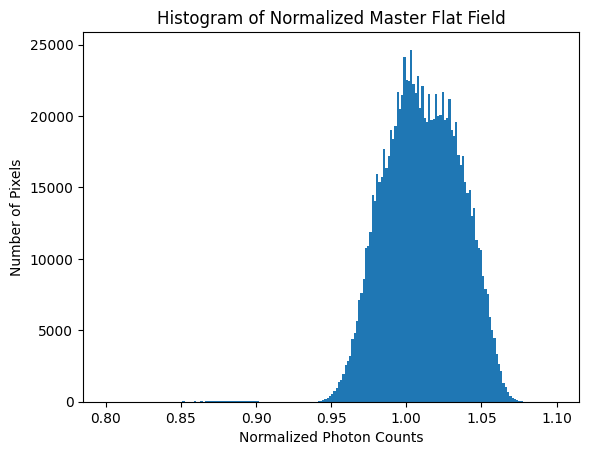

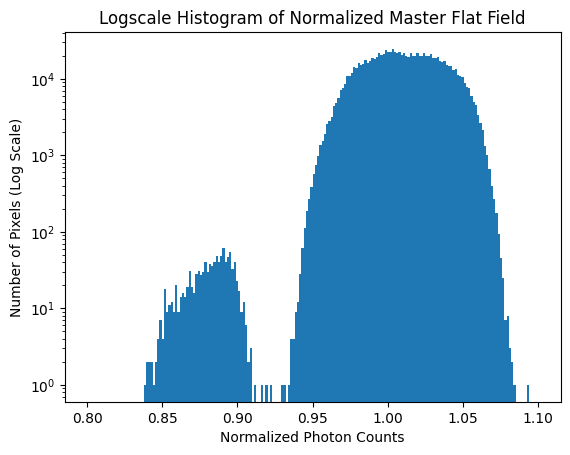

In [44]:
#4.3.4

def plot_normalized_histograms(norm_flat, range=(0.8, 1.1), bins=200):
    """
    Plot histograms of the normalized master flat field on both linear and logarithmic scales.

    :param norm_flat: The normalized master flat field data to be plotted.
    :type norm_flat: np.ndarray
    :param linear_range: The range of normalized photon counts for the linear histogram.
    :type linear_range: tuple
    :param bins: The number of bins to use for the histograms.
    :type bins: int
    :return: None
    """
    # Plot histogram on linear scale
    plt.hist(norm_flat.flatten(), range=range, bins=bins)
    plt.xlabel('Normalized Photon Counts')
    plt.ylabel('Number of Pixels')
    plt.title('Histogram of Normalized Master Flat Field')
    plt.show()

    # Plot histogram on log scale
    plt.hist(norm_flat.flatten(), range=range, bins=bins, log=True)
    plt.xlabel('Normalized Photon Counts')
    plt.ylabel('Number of Pixels (Log Scale)')
    plt.title('Logscale Histogram of Normalized Master Flat Field')
    plt.show()

# Call the function
plot_normalized_histograms(norm_flat)

The function `plot_normalized_histograms` is used to visualize the distribution of pixel values in the normalized master flat field through two types of histograms: one on a linear scale and one on a logarithmic scale. By plotting these histograms, we can assess the overall uniformity of the detector’s response and identify any variations or anomalies in the pixel values.

- The linear histogram shows how the pixel values are distributed relative to the normalized photon counts. This provides a straightforward way to see if the majority of pixel values are centered around the mode (which is the typical or most common value in the normalized flat field).
  
- The logarithmic histogram highlights the pixel distribution across a broader range of values, making it easier to detect low-frequency occurrences of outlier pixels that may not be easily visible in the linear scale.

Upon reviewing the histograms:
- The lowest pixel value is around 84% of the mode value, indicating that there are no dead pixels in the image, as dead pixels would have significantly lower counts, close to zero. This confirms that the uniform sensitivity of the detector is uniform.
- The log-scale histogram reveals two clusters of pixel values: one between 0.87 and 0.93 of the mode value, and another between 0.95 and 1.07. These clusters suggest that, while the flat field is generally consistent, there are distinct regions of the detector that respond slightly differently to illumination, possibly due to intrinsic variations in the detector's sensitivity.

4.3.5

Yes, the flat-fields can possibly be retaken later, but it is not recommended. The purpose of flat-fields is to correct for variations in the sensitivity of your detector and optical system, which can change over time due to factors like dust accumulation, changes in telescope alignment, or slight differences in lighting conditions. The longer time waited to take flat-fields, the higher the risk that new flats won’t accurately represent the conditions during the observation time. Ideally, flat-fields should be taken during the same observing session, under conditions as similar as possible to the science images, to ensure accurate calibration. Taking them later may introduce errors and reduce the effectiveness of the flat-field correction.